In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dfent = pd.read_csv("base_etablissement_par_tranche_effectif.csv")
dfgeo = pd.read_csv("name_geographic_information.csv")
dfsal = pd.read_csv("net_salary_per_town_categories.csv")
dfpop = pd.read_csv("population.csv",low_memory=False) #executer plusieurs fois, ça finit par fonctionner:)
dfent["TPE"]=dfent["E14TS1"]+dfent["E14TS6"]
dfent["PME_ETI"]=dfent["E14TS10"]+dfent["E14TS20"]+dfent["E14TS50"]+dfent["E14TS100"]+dfent["E14TS200"]
dfent["GE"] = dfent["E14TS500"]
dfgeo = dfgeo.rename(columns={'code_insee': 'CODGEO'})
#on enleve la colonne nivgeo qui sert à rien car une seule valeur
dfpop.drop("NIVGEO", axis=1,inplace=True)
#j'ajoute un zero et pour pouvoir comparer les CODGEO
dfgeo.loc[dfgeo.CODGEO < 10000,"CODGEO"] = dfgeo[dfgeo.CODGEO < 10000]["CODGEO"].apply(lambda x : str("0"+str(x)))
#je convertis le reste des colonnes
dfgeo.CODGEO = dfgeo.CODGEO.astype("string")
df_full = pd.merge(dfsal,dfent,on="CODGEO")
#calcul de l'âge moyenne 'indicatif'
dfpop.CODGEO = dfpop.CODGEO.astype("string")
dfpop["ratio"] = dfpop.AGEQ80_17*dfpop.NB
dfpop_sum = dfpop.groupby("CODGEO").agg({"NB":"sum"})
dfpop_ratio = dfpop.groupby("CODGEO").agg({"ratio":"sum"})
dfpop_sum = pd.merge(dfpop_sum,dfpop_ratio,on="CODGEO")
dfpop_sum["age_moyen"]= dfpop_sum["ratio"]/dfpop_sum["NB"]
df_full = pd.merge(df_full,dfpop_sum,on="CODGEO")
#mettre le nb homme/femme
dfpop_sexe=dfpop.groupby(["CODGEO","SEXE"]).agg({"NB":"sum"})
dfpop_sexe = dfpop_sexe.reset_index(drop=False).pivot(index='CODGEO', columns='SEXE', values='NB')
dfpop_sexe.columns = ["Homme","Femme"]
df_full = pd.merge(df_full,dfpop_sexe,on="CODGEO")
df_full["ratio_homme"]=df_full["Homme"]/(df_full["Homme"]+df_full["Femme"])
df_full["pop_totale"]=(df_full["Homme"]+df_full["Femme"])
dfgeo_pour_merged = dfgeo[["CODGEO","numéro_département"]].drop_duplicates()
df_full = pd.merge(df_full, dfgeo_pour_merged, on="CODGEO")
dfpop_moco = dfpop.groupby(["CODGEO","MOCO"]).agg({"NB":"sum"}).reset_index(drop=False).pivot(index='CODGEO', columns='MOCO', values='NB')
dfpop_moco.columns =["e2p","e1p","ac","ace","ase","str","solo"]
dfpop_moco["total"] = dfpop_moco["e2p"]+dfpop_moco["e1p"]+ dfpop_moco["ac"]+dfpop_moco["ace"]+ dfpop_moco["ase"]+dfpop_moco["str"]+dfpop_moco["solo"]
dfpop_moco.drop_duplicates(inplace=True)
numdept = pd.read_csv("departements-region.csv")
df_full.rename(columns={"numéro_département":"num_dep"},inplace=True)
df_full = pd.merge(df_full, numdept, on="num_dep")
dfpop.AGEQ80_17 = dfpop.AGEQ80_17.replace({0:"enfant",5:"enfant",10:"enfant",15:"enfant",20:"enfant",25:"jeune actif",30:"jeune actif",35:"actif",40:"actif", 45:"actif",50:"actif",55:"senior actif",60:"senior actif", 65:"senior",70:"senior",75:"senior",80:"senior"})
dfpop_grouped = dfpop.groupby(["CODGEO","AGEQ80_17"]).agg({"NB":"sum"})
dfpop_grouped = dfpop_grouped.reset_index(drop=False)
df_test = dfpop_grouped.pivot(index='CODGEO', columns='AGEQ80_17', values='NB').reset_index()
df_full= pd.merge(df_full, df_test, on="CODGEO")
#a partir de là on a le df_full
df_full.rename(columns={"SNHM14":"Salaire moyen","E14TST":"Nb d'entreprises"},inplace=True)
df_full = pd.merge(df_full,dfpop_moco,on="CODGEO")
df_full.drop_duplicates(inplace=True)
df_full.rename(columns={'Salaire moyen': 'Salaire_moyen'},inplace=True)
dfgeo_dept = dfgeo[["CODGEO","nom_département"]]
df_full = pd.merge(df_full, dfgeo_dept, on="CODGEO")
df_full.drop_duplicates(inplace=True)
df_densite = pd.read_csv("densite-commune.csv")
df_full = pd.merge(df_full, df_densite, on = "CODGEO")
df_full.densite_commune = df_full.densite_commune.replace({"Communes très peu denses" : 0, "Communes peu denses":1,"Communes de densité intermédiaire":2,"Communes densément peuplées":3})
df_full["IDF"] = df_full.region_name == "Île-de-France"
df_full.IDF = df_full.IDF.replace({True : 1, False:0})

In [35]:
df_full["ratio_solo"] = df_full["solo"] / df_full["total"] #personnes qui vivent seules
df_full["ratio_e2p"] = df_full["e2p"] / df_full["total"] #enfant avec 2 parents
df_full["ratio_ase"] = df_full["ase"] / df_full["total"]#adulte sans enfant
df_full["ratio_e1p"] = df_full["e1p"] / df_full["total"]#enfant avec un parent
df_full["ratio_ac"] = df_full["ac"] / df_full["total"]#adulte en couple
df_full["ratio_ace"] = df_full["ace"] / df_full["total"]#adulte en couple avec enfant
df_full["ratio_str"] = df_full["str"] / df_full["total"]#adulte qui vivent avec des gens qui ne font pas parti de leur famille
df_full["ratio_femme"]=df_full["Femme"]/(df_full["Homme"]+df_full["Femme"])
df_full["ratio_homme"]=df_full["Homme"]/(df_full["Homme"]+df_full["Femme"])
df_full["ratio_GE"] = df_full["GE"] / df_full["Nb d'entreprises"]#grands groupes
df_full["ratio_PME"] = df_full["PME_ETI"] / df_full["Nb d'entreprises"]#PME/ETI
df_full["ratio_TPE"] = df_full["TPE"] / df_full["Nb d'entreprises"]#TPE
df_full["ratio_enfant"] = df_full["enfant"]/(df_full["enfant"]+df_full["jeune actif"]+df_full["actif"]+df_full["senior"]+df_full["senior actif"])
df_full["ratio_jeune_actif"] = df_full["jeune actif"]/(df_full["enfant"]+df_full["jeune actif"]+df_full["actif"]+df_full["senior"]+df_full["senior actif"])
df_full["ratio_actif"] = df_full["actif"]/(df_full["enfant"]+df_full["jeune actif"]+df_full["actif"]+df_full["senior"]+df_full["senior actif"])
df_full["ratio_senior_actif"] = df_full["senior actif"]/(df_full["enfant"]+df_full["jeune actif"]+df_full["actif"]+df_full["senior"]+df_full["senior actif"])
df_full["ratio_senior"] = df_full["senior"]/(df_full["enfant"]+df_full["jeune actif"]+df_full["actif"]+df_full["senior"]+df_full["senior actif"])

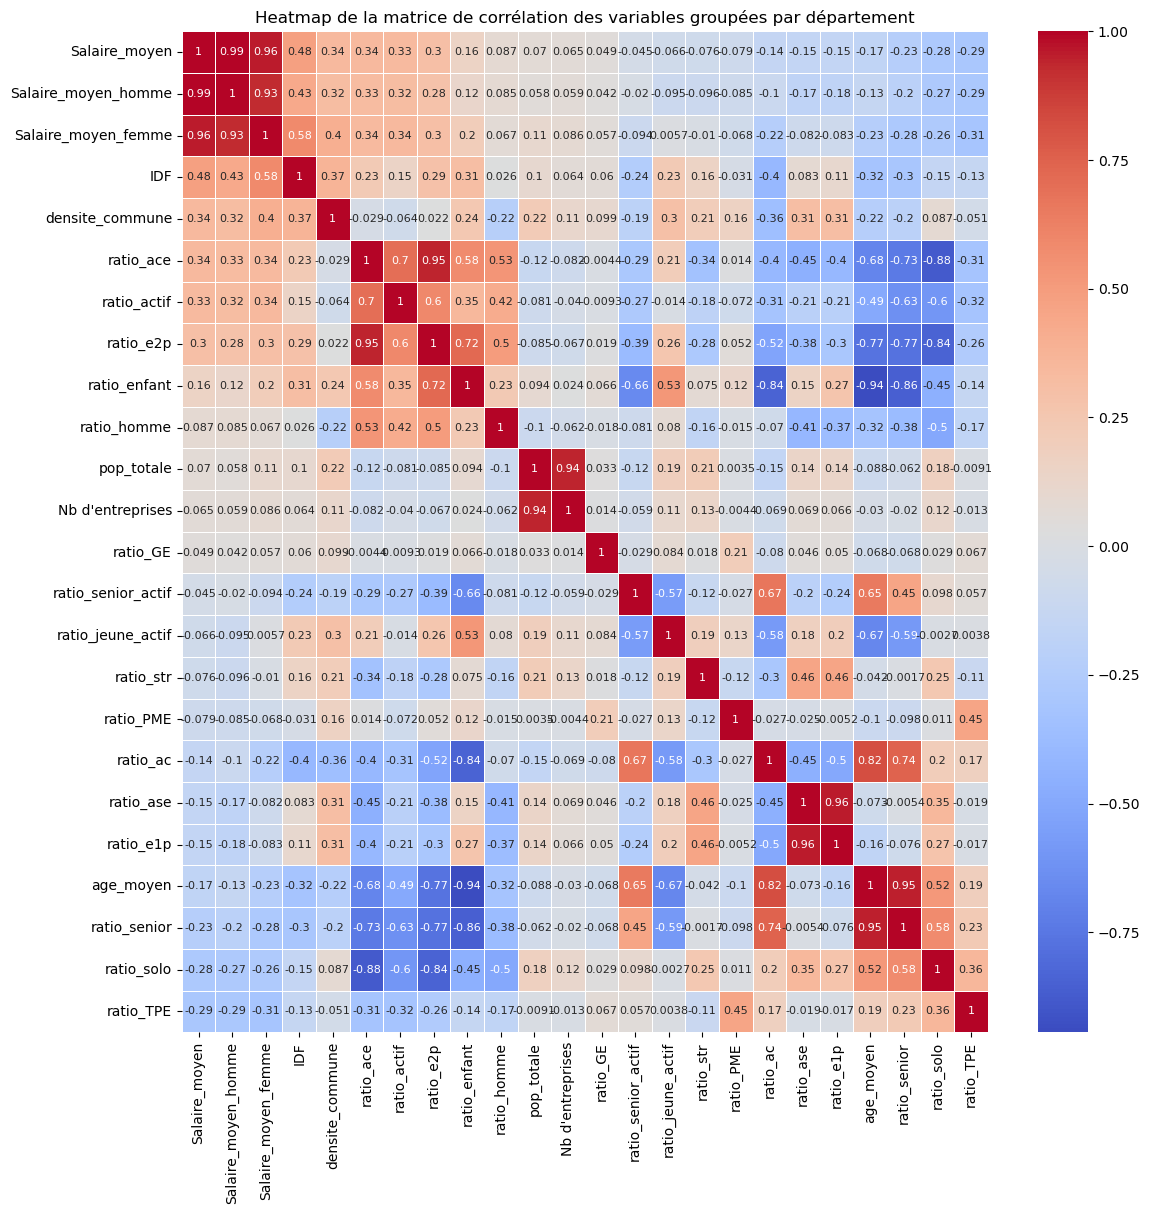

In [88]:
#matrice de correlation après groupement par département
correlation_matrix_full = df_full[['Salaire_moyen','Salaire_moyen_homme','Salaire_moyen_femme', 'IDF', 'densite_commune', 'ratio_ace', 'ratio_actif', #IDF = appartient ou pas à l'IDF
       'ratio_e2p', 'ratio_enfant', 'ratio_homme', 'pop_totale',
       "Nb d'entreprises", 'ratio_GE', 'ratio_senior_actif',
       'ratio_jeune_actif', 'ratio_str', 'ratio_PME', 'ratio_ac', 'ratio_ase',
       'ratio_e1p', 'age_moyen', 'ratio_senior', 'ratio_solo', 'ratio_TPE']].corr()

plt.figure(figsize=(13, 13))
sns.heatmap(correlation_matrix_full, annot=True, cmap='coolwarm', linewidths=0.5,annot_kws={"size": 8})
plt.title('Heatmap de la matrice de corrélation des variables groupées par département')
plt.show()

In [55]:
correlation_matrix_full.Salaire_moyen.sort_values(ascending=False).index

Index(['Salaire_moyen', 'IDF', 'densite_commune', 'ratio_ace', 'ratio_actif',
       'ratio_e2p', 'ratio_enfant', 'ratio_homme', 'pop_totale',
       'Nb d'entreprises', 'ratio_GE', 'ratio_senior_actif',
       'ratio_jeune_actif', 'ratio_str', 'ratio_PME', 'ratio_ac', 'ratio_ase',
       'ratio_e1p', 'age_moyen', 'ratio_senior', 'ratio_solo', 'ratio_TPE'],
      dtype='object')

In [59]:
df_full.columns

Index(['CODGEO', 'LIBGEO_x', 'Salaire_moyen', 'SNHMC14', 'SNHMP14', 'SNHME14',
       'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14', 'SNHMFE14', 'SNHMFO14',
       'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14', 'SNHMHO14', 'SNHM1814',
       'SNHM2614', 'SNHM5014', 'SNHMF1814', 'SNHMF2614', 'SNHMF5014',
       'SNHMH1814', 'SNHMH2614', 'SNHMH5014', 'LIBGEO_y', 'REG', 'DEP',
       'Nb d'entreprises', 'E14TS0ND', 'E14TS1', 'E14TS6', 'E14TS10',
       'E14TS20', 'E14TS50', 'E14TS100', 'E14TS200', 'E14TS500', 'TPE',
       'PME_ETI', 'GE', 'NB', 'ratio', 'age_moyen', 'Homme', 'Femme',
       'ratio_homme', 'pop_totale', 'num_dep', 'dep_name', 'region_name',
       'actif', 'enfant', 'jeune actif', 'senior', 'senior actif', 'e2p',
       'e1p', 'ac', 'ace', 'ase', 'str', 'solo', 'total', 'nom_département',
       'densite_commune', 'ratio_solo', 'ratio_e2p', 'ratio_ase', 'ratio_e1p',
       'ratio_ac', 'ratio_ace', 'ratio_str', 'ratio_femme', 'ratio_GE',
       'ratio_PME', 'ratio_TPE', 'ra

C:\Users\manpe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


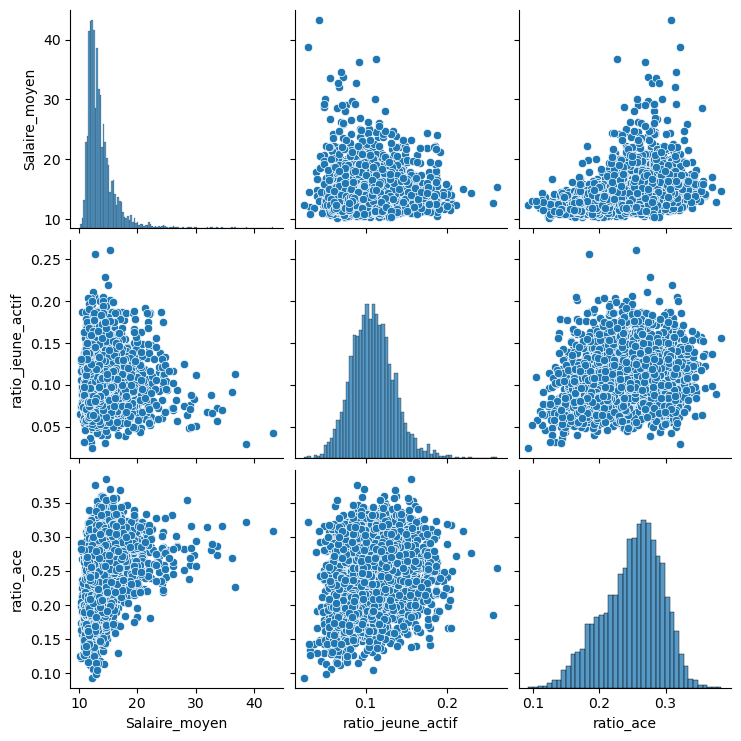

NameError: name 'df_full_region' is not defined

In [61]:
sns.pairplot(data = df_full[['Salaire_moyen',"ratio_jeune_actif",'ratio_ace']])
plt.show()

sns.lmplot(x = "Salaire moyen", y = "Nb d'entreprises", lowess = True, data = df_full_region)
sns.lmplot(x = "Salaire moyen", y = "pop_totale", lowess = True, data = df_full_region)
plt.show()

C:\Users\manpe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


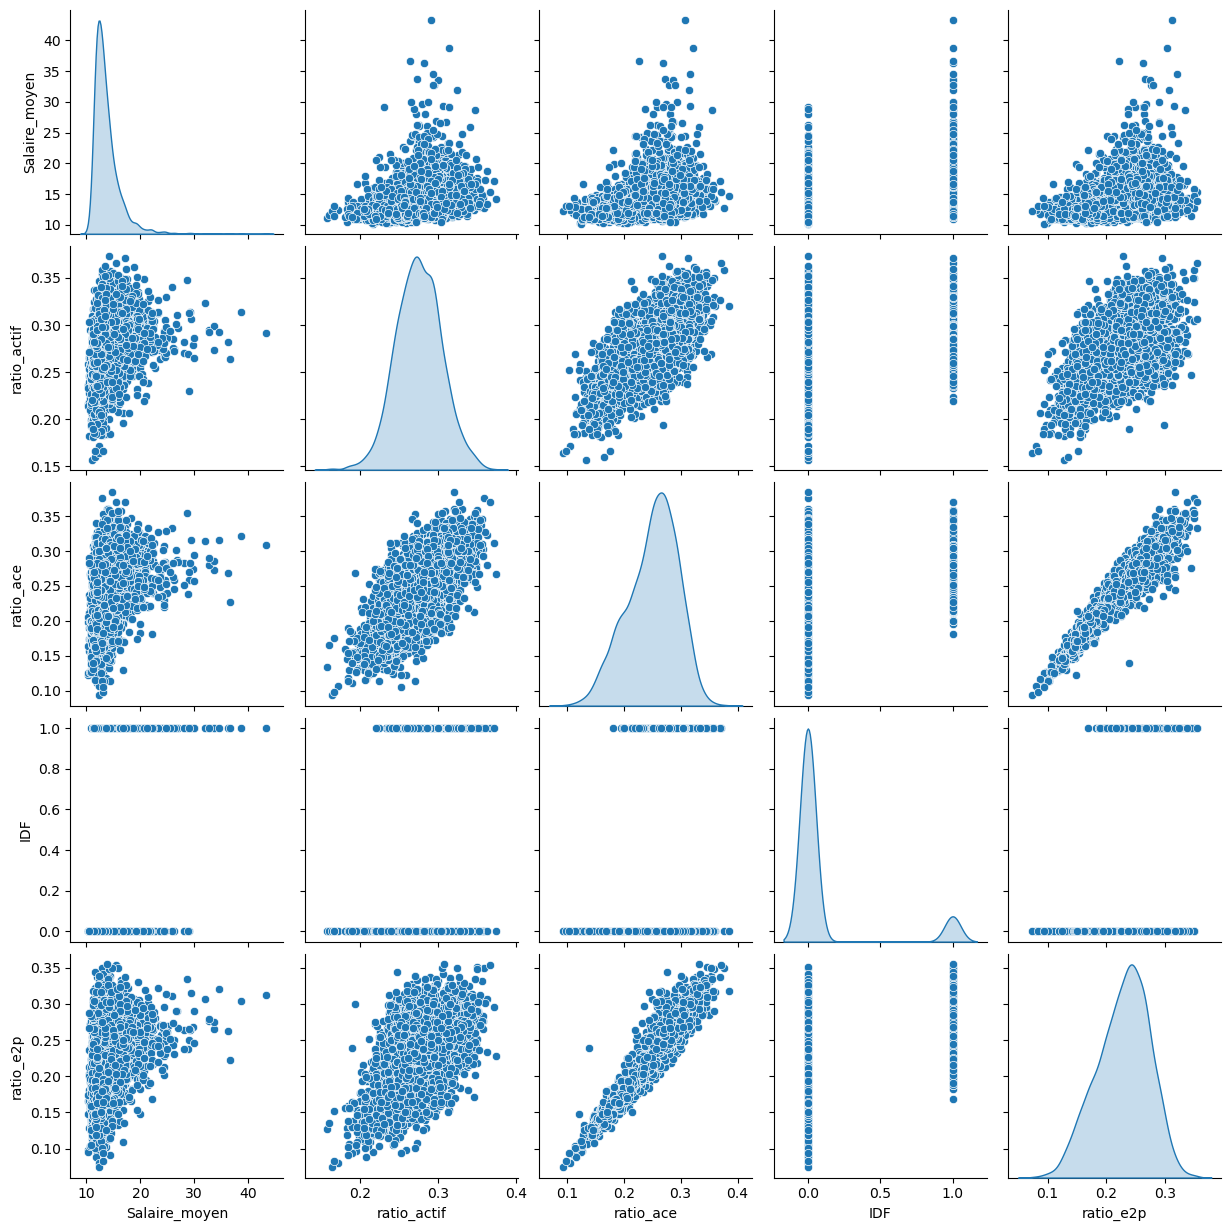

In [73]:
sns.pairplot(data = df_full[['Salaire_moyen',"ratio_actif",'ratio_ace',"IDF","ratio_e2p"]], diag_kind = "kde");
plt.show();


C:\Users\manpe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


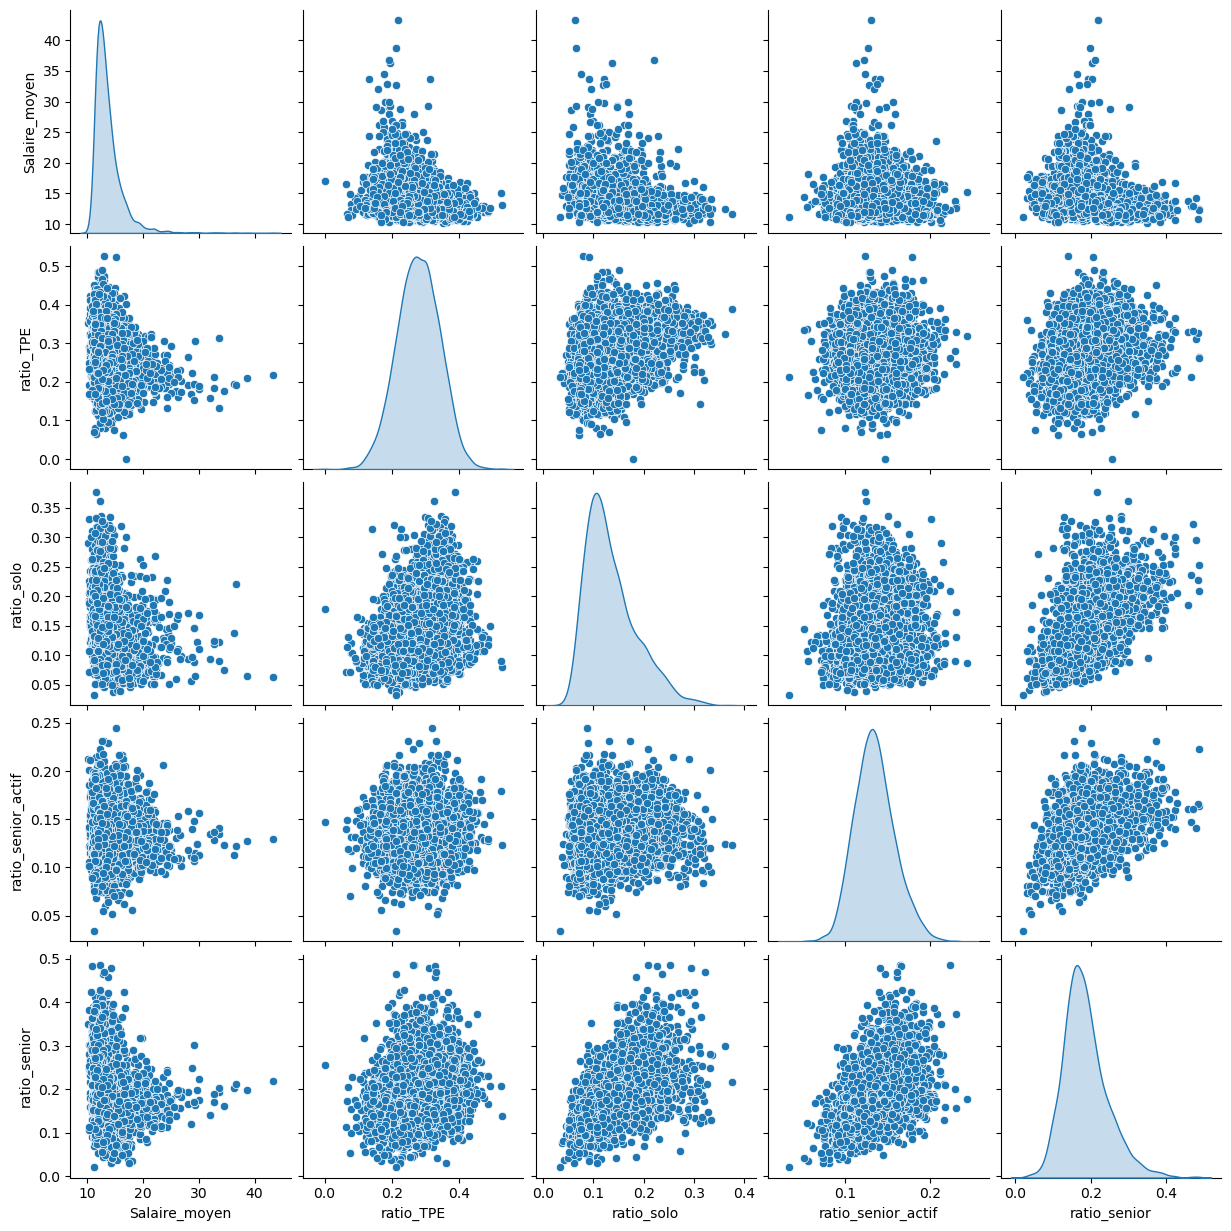

In [74]:
sns.pairplot(data = df_full[['Salaire_moyen',"ratio_TPE","ratio_solo","ratio_senior_actif","ratio_senior"]], diag_kind = "kde");
plt.show();


In [78]:
print("Les hypothèses : ")
print("H0 : Il n'y a pas d'influence significative de la région sur le nb d'entreprises")
print("H1 : Il y a une influence significative de la région sur le nb d'entreprises")

# Importer la librairie 
import statsmodels.api

dfentanova = df_full[["Salaire_moyen","densite_commune"]]
# Réalisation du test ANOVA et affichage de résultats
result = statsmodels.formula.api.ols('Salaire_moyen ~ densite_commune', data=dfentanova).fit()
display(statsmodels.api.stats.anova_lm(result))

print("p<5% => on rejette H0 et on accepte H1 => Il y a une influence significative de la région sur le nb d'entreprises")

Les hypothèses : 
H0 : Il n'y a pas d'influence significative de la région sur le nb d'entreprises
H1 : Il y a une influence significative de la région sur le nb d'entreprises


,df,sum_sq,mean_sq,F,PR(>F)
densite_commune,1.0,3867.811973,3867.811973,678.547263,1.867271e-140
Residual,5044.0,28751.488132,5.700136,NaN,NaN


p<5% => on rejette H0 et on accepte H1 => Il y a une influence significative de la région sur le nb d'entreprises


In [76]:
df_full.columns

Index(['CODGEO', 'LIBGEO_x', 'Salaire_moyen', 'SNHMC14', 'SNHMP14', 'SNHME14',
       'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14', 'SNHMFE14', 'SNHMFO14',
       'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14', 'SNHMHO14', 'SNHM1814',
       'SNHM2614', 'SNHM5014', 'SNHMF1814', 'SNHMF2614', 'SNHMF5014',
       'SNHMH1814', 'SNHMH2614', 'SNHMH5014', 'LIBGEO_y', 'REG', 'DEP',
       'Nb d'entreprises', 'E14TS0ND', 'E14TS1', 'E14TS6', 'E14TS10',
       'E14TS20', 'E14TS50', 'E14TS100', 'E14TS200', 'E14TS500', 'TPE',
       'PME_ETI', 'GE', 'NB', 'ratio', 'age_moyen', 'Homme', 'Femme',
       'ratio_homme', 'pop_totale', 'num_dep', 'dep_name', 'region_name',
       'actif', 'enfant', 'jeune actif', 'senior', 'senior actif', 'e2p',
       'e1p', 'ac', 'ace', 'ase', 'str', 'solo', 'total', 'nom_département',
       'densite_commune', 'ratio_solo', 'ratio_e2p', 'ratio_ase', 'ratio_e1p',
       'ratio_ac', 'ratio_ace', 'ratio_str', 'ratio_femme', 'ratio_GE',
       'ratio_PME', 'ratio_TPE', 'ra

In [80]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
x = df_full["Salaire_moyen"]
y = df_full["Nb d'entreprises"]
print("Salaire moyen x Nb entreprises")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["pop_totale"]
print("Salaire moyen x Pop totale")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["ratio_ac"]
print("Salaire moyen x Ratio adultes en couple sans enfant")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["ratio_str"]
print("Salaire moyen x Ratio personne étrangère au foyer")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["age_moyen"]
print("Salaire moyen x Age moyen")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["ratio_GE"]
print("Salaire moyen x Ratio grandes entreprises")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["ratio_TPE"]
print("Salaire moyen x Ratio TPE")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["part_jeunedip_pasetudes"]
print("Salaire moyen x part jeunes diplomés pas en études")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["densite"]
print("Salaire moyen x densité")
print(spearmanr(x,y))
print(pearsonr(x,y))

x = df_full["Salaire_moyen"]
y = df_full["ratio_senior_actif"]
print("Salaire moyen x raio senior actif")
print(spearmanr(x,y))
print(pearsonr(x,y))


x = df_full["Salaire_moyen"]
y = df_full["chomage"]

print("Salaire moyen x chomage") #pas d'influence par exemple
print(spearmanr(x,y))
print(pearsonr(x,y))


Salaire moyen x Nb entreprises
SignificanceResult(statistic=0.10424508597528785, pvalue=1.1409222094593924e-13)
PearsonRResult(statistic=0.06547742506151748, pvalue=3.239091036079028e-06)
Salaire moyen x Pop totale
SignificanceResult(statistic=0.0940247314506325, pvalue=2.197790939358036e-11)
PearsonRResult(statistic=0.06961497857215146, pvalue=7.425366275981293e-07)
Salaire moyen x Ratio adultes en couple sans enfant
SignificanceResult(statistic=-0.16173137598055726, pvalue=6.422006812539383e-31)
PearsonRResult(statistic=-0.14383691194758505, pvalue=9.782496073887579e-25)
Salaire moyen x Ratio personne étrangère au foyer
SignificanceResult(statistic=-0.11462152264659943, pvalue=3.1595707051856767e-16)
PearsonRResult(statistic=-0.0756047046773694, pvalue=7.575327977298518e-08)
Salaire moyen x Age moyen
SignificanceResult(statistic=-0.25420099285041753, pvalue=3.0076421218142357e-75)
PearsonRResult(statistic=-0.16829065027384302, pvalue=2.255658159264161e-33)
Salaire moyen x Ratio grand

KeyError: 'part_jeunedip_pasetudes'

In [82]:
col = ['Salaire_moyen', 'IDF', 'densite_commune', 'ratio_ace', 'ratio_actif', #IDF = appartient ou pas à l'IDF
       'ratio_e2p', 'ratio_enfant', 'ratio_homme', 'pop_totale',
       "Nb d'entreprises", 'ratio_GE', 'ratio_senior_actif',
       'ratio_jeune_actif', 'ratio_str', 'ratio_PME', 'ratio_ac', 'ratio_ase',
       'ratio_e1p', 'age_moyen', 'ratio_senior', 'ratio_solo', 'ratio_TPE']

for n in col :
    x = df_full["Salaire_moyen"]
    y = df_full[n]
    print("Salaire moyen x",n)
    print(spearmanr(x,y))
    print(pearsonr(x,y))

Salaire moyen x Salaire_moyen
SignificanceResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
Salaire moyen x IDF
SignificanceResult(statistic=0.38160130922228575, pvalue=1.2387682804564483e-174)
PearsonRResult(statistic=0.48330142654958647, pvalue=9.794677542244199e-294)
Salaire moyen x densite_commune
SignificanceResult(statistic=0.3411401143247019, pvalue=1.006640052921082e-137)
PearsonRResult(statistic=0.34434624980065875, pvalue=1.8672713857982793e-140)
Salaire moyen x ratio_ace
SignificanceResult(statistic=0.4522268012548913, pvalue=6.26444982276643e-253)
PearsonRResult(statistic=0.34256116987012064, pvalue=6.253147466369127e-139)
Salaire moyen x ratio_actif
SignificanceResult(statistic=0.4575317072339586, pvalue=1.3382659417283078e-259)
PearsonRResult(statistic=0.33167776634808555, pvalue=7.555061865198103e-130)
Salaire moyen x ratio_e2p
SignificanceResult(statistic=0.35996355040661226, pvalue=3.145862969267519e-154)
PearsonRResult(statistic=0.30210748390

In [84]:
df_full.rename(columns={'SNHMF14': 'Salaire_moyen_femme',"SNHMH14":"Salaire_moyen_homme"},inplace=True)


In [7]:
df_full[df_full.REG == 82][["REG","region_name"]]

,REG,region_name
0,82,Auvergne-Rhône-Alpes
1,82,Auvergne-Rhône-Alpes
2,82,Auvergne-Rhône-Alpes
3,82,Auvergne-Rhône-Alpes
4,82,Auvergne-Rhône-Alpes
...,...,...
3841,82,Auvergne-Rhône-Alpes
3842,82,Auvergne-Rhône-Alpes
3843,82,Auvergne-Rhône-Alpes
3844,82,Auvergne-Rhône-Alpes
